In [374]:
#Importamos todas las librerias necesarias
import notebook
import sys
import sklearn
import matplotlib
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
from sklearn.tree import plot_tree

In [375]:
#Mostramos las versiones con las cuales trabajasmo, para que puedan ser reproducidos.
print("Versiones del entorno")
print("Python:", sys.version.split()[0])
print()
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)
print("yfinance:", yf.__version__)
print("Jupyter Notebook:", notebook.__version__)

Versiones del entorno
Python: 3.12.8

numpy: 2.0.2
pandas: 2.2.3
scikit-learn: 1.6.1
matplotlib: 3.10.0
yfinance: 0.2.66
Jupyter Notebook: 7.3.2


# Descargamos los datos.

In [264]:
#primero descargamos nuestros datos y los guardamos en el mismo archivo, en caso de caso que ya se
#tengan descargados no ejecutamos esto, como sera la primera vez hacemos este paso.

#Para ambos archivos tomamos los datos diarios, pero también se pueden tomar en semanas o meses
#Para las divisas descargamos los datos mas antiguos porque nos dan información

def descargar_y_guardar(ticker, start, archivo): #ticker para poder ver como se llaman los datos que requerimos., el comienzo y el nombre que le daremos a nuestro archivo.
    df = yf.download(ticker, start=start, interval="1d", auto_adjust=True)

    # nos quedamos con 'Close', esto para evitar la columna de date que nos da cuando descargamos los datos
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
#guradamos el archivo con el nombre dado
    df.to_csv(archivo)
    return df

btc = descargar_y_guardar("BTC-USD", "2023-01-01", "historial_bitcoin.csv")
divp = descargar_y_guardar("MXN=X", "2003-01-01", "historial_divisasenpesos.csv")

print("¡Datos guardados bien!")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

¡Datos guardados bien!


# Procesamiento de Datos

In [265]:
#Usamos la funcion de pandas para cargar archivos y guardarlos en una variable
#Caundo ya tengamos los archivos en el mismo lugar donde corre el notebook ya solo ejecutamos desde aqui, y ya 
#no seria necesario descargarlo, (descargamos en caso de requerir datos mas recientes) los datos son 
#para las divisaenpesos de 2003-01-01 a 2025-12-12 y el bitcoin de 2023-01-01 a 2025-12-12

#colocamos index_col=0 para decir que no es un dato solo una forma de separar los datos.
#Y le damos el formato en la cual estan las fechas estas las podemos ver abriendo los archivos

datos_btc = pd.read_csv("historial_bitcoin.csv", index_col=0, parse_dates=True,  date_format='%Y-%m-%d')
datos_divp = pd.read_csv("historial_divisasenpesos.csv", index_col=0, parse_dates=True,  date_format='%Y-%m-%d')


In [266]:
# Ahora revisamos que los datos esten cargados, en teoria si se cargan bien deberiamos ver un numero alto de filas
#y en columnas deberian ser alrededor de 5 en los archivos vemos que son 6 columnas pero ya le dijismos a panda que
#la columna de fecha es el indice de nuestros datos
#primero los datos de btc
print(f"Datos cargados: {datos_btc.shape}")
datos_btc.head(3)

Datos cargados: (1079, 5)


Close          High           Low          Open  \
Date                                                                 
2023-01-01  16625.080078  16630.439453  16521.234375  16547.914062   
2023-01-02  16688.470703  16759.343750  16572.228516  16625.509766   
2023-01-03  16679.857422  16760.447266  16622.371094  16688.847656   

                 Volume  
Date                     
2023-01-01   9244361700  
2023-01-02  12097775227  
2023-01-03  13903079207

In [267]:
#Despues los datos de las divisas
print(f"Datos cargados: {datos_divp.shape}")
datos_divp.head(5)

Datos cargados: (5740, 5)


Close     High      Low     Open  Volume
Date                                                 
2003-12-01  11.358  11.4250  11.1776  11.1776       0
2003-12-02  11.290  11.3800  11.2740  11.3605       0
2003-12-03  11.245  11.3605  11.1860  11.3605       0
2003-12-04  11.188  11.3550  11.1590  11.3550       0
2003-12-05  11.197  11.2400  11.1230  11.1860       0

In [268]:
#Ahora comenzamos a tratar los datos, para esto primero tenemos que ver que 
#queremos hacer, como vamos a predecir futuros valores, y tenemos un conjunto de datos
#en ordenados por fecha, buscaremos si hay alguna relación con precios pasas,
#osea que el precio de mañana de las divisas va a depender del comportamiento que tuvieron en dias 
#anteriores.

#Entonces de nuestro cunjuto de datos deberemos de Seleccionar datos en serie y por fecha
#Ponemos el valor objetivo por ejemplo vamos decir que el valor Y=(div_t) es el valor de la divisa 
#en un dia cualquiera y este depende de X=[div_t-1... div_t-n] osea depende del valor de
#las divisas en dias anteriores, y de esta forma tenemos nuestras variables objetivos y caractaristicas
#que el modelos de aprendizaje nos piden.


#Para cada conjunto extraemos solo el valor de la columna de cierro osea la columna 'Close'
#y asi creamos una especie de serie de fechas con un valor del bitcoin o de la divisa según sea
#el caso

serie_btc = pd.to_numeric(datos_btc["Close"], errors="coerce").dropna()
serie_divp = pd.to_numeric(datos_divp["Close"], errors="coerce").dropna()

# Caso Valor del Tipo de Cambio entre Divisas (USD/MXN) Árbol de Regresión.

In [ ]:
#Construimos las X y las Y para poder trabajar con ellas

In [269]:
def construir_X_divp(serie, n=5):
    
    df = pd.DataFrame(serie.copy())
    df.columns = ["Divisa_t"]  # nombre de la columna objetivo

    # Crear columnas para divisas anteriores
    for lag in range(1, n + 1):
        df[f"Divisa_t-{lag}"] = df["Divisa_t"].shift(lag)
    df = df.dropna()

    # Se reordenan los datos
    cols_features = [f"Divisa_t-{lag}" for lag in range(n, 0, -1)]
    cols = cols_features + ["Divisa_t"]
    df = df[cols]

    return df

In [340]:
#Recordamos que este tipo de aprendizaje es un aprendizaje supervisado ya que se entrenara con datos que 
#ya conocemos, lo contruimos con nuestra funcion construir, y usamos el atributo .head para ver como se ve
df_supervisado = construir_X_divp(serie_divp, n=15)
df_supervisado.head()

Divisa_t-15  Divisa_t-14  Divisa_t-13  Divisa_t-12  Divisa_t-11  \
Date                                                                          
2003-12-22       11.358       11.290       11.245       11.188       11.197   
2003-12-23       11.290       11.245       11.188       11.197       11.202   
2003-12-24       11.245       11.188       11.197       11.202       11.162   
2003-12-25       11.188       11.197       11.202       11.162       11.207   
2003-12-26       11.197       11.202       11.162       11.207       11.109   

            Divisa_t-10  Divisa_t-9  Divisa_t-8  Divisa_t-7  Divisa_t-6  \
Date                                                                      
2003-12-22       11.202     11.1620     11.2070     11.1090     11.2650   
2003-12-23       11.162     11.2070     11.1090     11.2650     11.2896   
2003-12-24       11.207     11.1090     11.2650     11.2896     11.2390   
2003-12-25       11.109     11.2650     11.2896     11.2390     11.2080   
2003-12-26       11.265     11.2896     11.2390     11.2080     11.2281   

            Divisa_t-5  Divisa_t-4  Divisa_t-3  Divisa_t-2  Divisa_t-1  \
Date                                                                     
2003-12-22     11.2896     11.2390     11.2080     11.2281      11.220   
2003-12-23     11.2390     11.2080     11.2281     11.2200      11.270   
2003-12-24     11.2080     11.2281     11.2200     11.2700      11.246   
2003-12-25     11.2281     11.2200     11.2700     11.2460      11.247   
2003-12-26     11.2200     11.2700     11.2460     11.2470      11.247   

            Divisa_t  
Date                  
2003-12-22    11.270  
2003-12-23    11.246  
2003-12-24    11.247  
2003-12-25    11.247  
2003-12-26    11.192

In [341]:
#Esto se hace sin hacer la division ose solo poner todos los datos para entrenar
# X: todas las columnas menos Divisa_t
X = df_supervisado.drop(columns=["Divisa_t"])

# Y: solo la columna Divisa_t
y = df_supervisado["Divisa_t"]

In [342]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

print(f"Entrenamos con los primeros {len(X_train)} días")
print(f"Probamos con los últimos {len(X_test)} días")

Entrenamos con los primeros 5152 días
Probamos con los últimos 573 días


## Primer modelo:  modelo_arbol2

In [343]:
modelo_arbol2 = DecisionTreeRegressor(max_depth=5, random_state=0)
modelo_arbol2.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=0)

In [344]:
#Ahora predecimos los posibles valores con nuestros valores de x test osea de prueba
#Se lo pasamos al modelo, con el metodo .predict lo que hace es
# nos arroja los valores de Y que piensa que seran y luego estos valores los comparamos con los valores que 
# ya conocemos

y_pred_test = modelo_arbol2.predict(X_test)

In [345]:
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.14077801220365463
RMSE: 0.18230308236877302


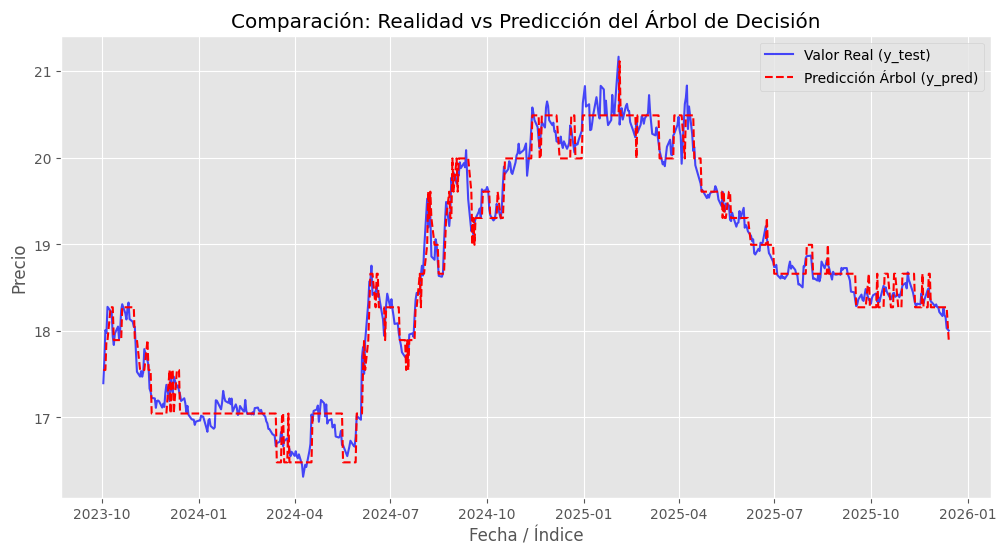

In [346]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Valor Real (y_test)', color='blue', alpha=0.7)
plt.plot(y_test.index, y_pred_test, label='Predicción Árbol (y_pred)', color='red', linestyle='--')

plt.title('Comparación: Realidad vs Predicción del Árbol de Decisión')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True) 
plt.show()

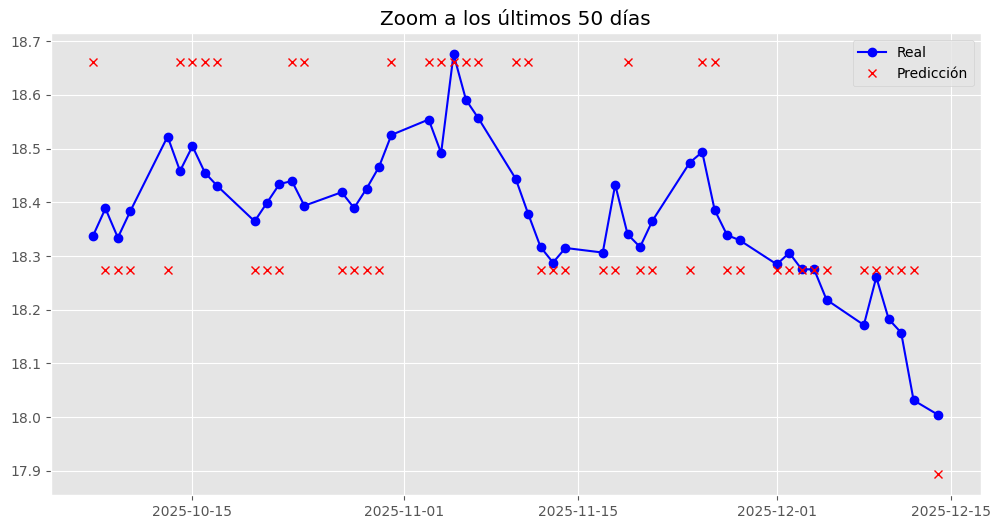

In [347]:
plt.figure(figsize=(12, 6))

# Tomamos unos pocos dias atras, para hacerle zoom y ver el comportamiento.
diasatras = 50

plt.plot(y_test.index[-diasatras:], y_test[-diasatras:], label='Real', color='blue', marker='o')
plt.plot(y_test.index[-diasatras:], y_pred_test[-diasatras:], label='Predicción', color='red', linestyle='none', marker='x')

plt.title(f'Zoom a los últimos {diasatras} días')
plt.legend()
plt.grid(True)
plt.show()

## Segundo modelo: modelo_mejorado

In [348]:
modelo_mejorado = DecisionTreeRegressor(
    criterion='absolute_error',  # En vez de 'squared_error' (el default)
    max_depth=10,                 # Profundidad
    min_samples_leaf=2,         # Mínimo de datos por hoja (ayuda a generalizar)
    random_state=0
)

modelo_mejorado.fit(X_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=10,
                      min_samples_leaf=2, random_state=0)

In [349]:
y_pred_test2 = modelo_mejorado.predict(X_test)

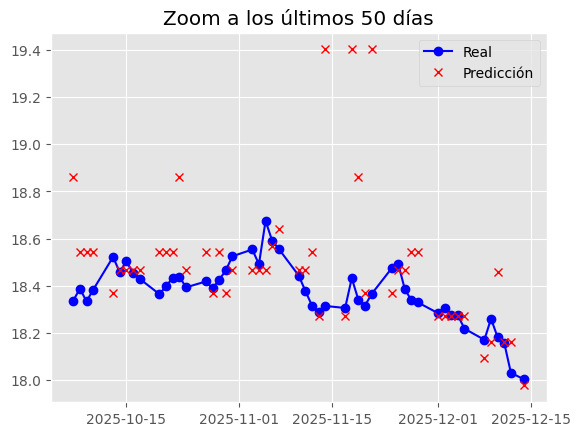

In [350]:
# Tomamos unos pocos dias atras, para hacerle zoom y ver el comportamiento.
diasatras = 50

plt.plot(y_test.index[-diasatras:], y_test[-diasatras:], label='Real', color='blue', marker='o')
plt.plot(y_test.index[-diasatras:], y_pred_test2[-diasatras:], label='Predicción', color='red', linestyle='none', marker='x')

plt.title(f'Zoom a los últimos {diasatras} días')
plt.legend()
plt.grid(True)
plt.show()

## Esquemas de los arbolres de decision.

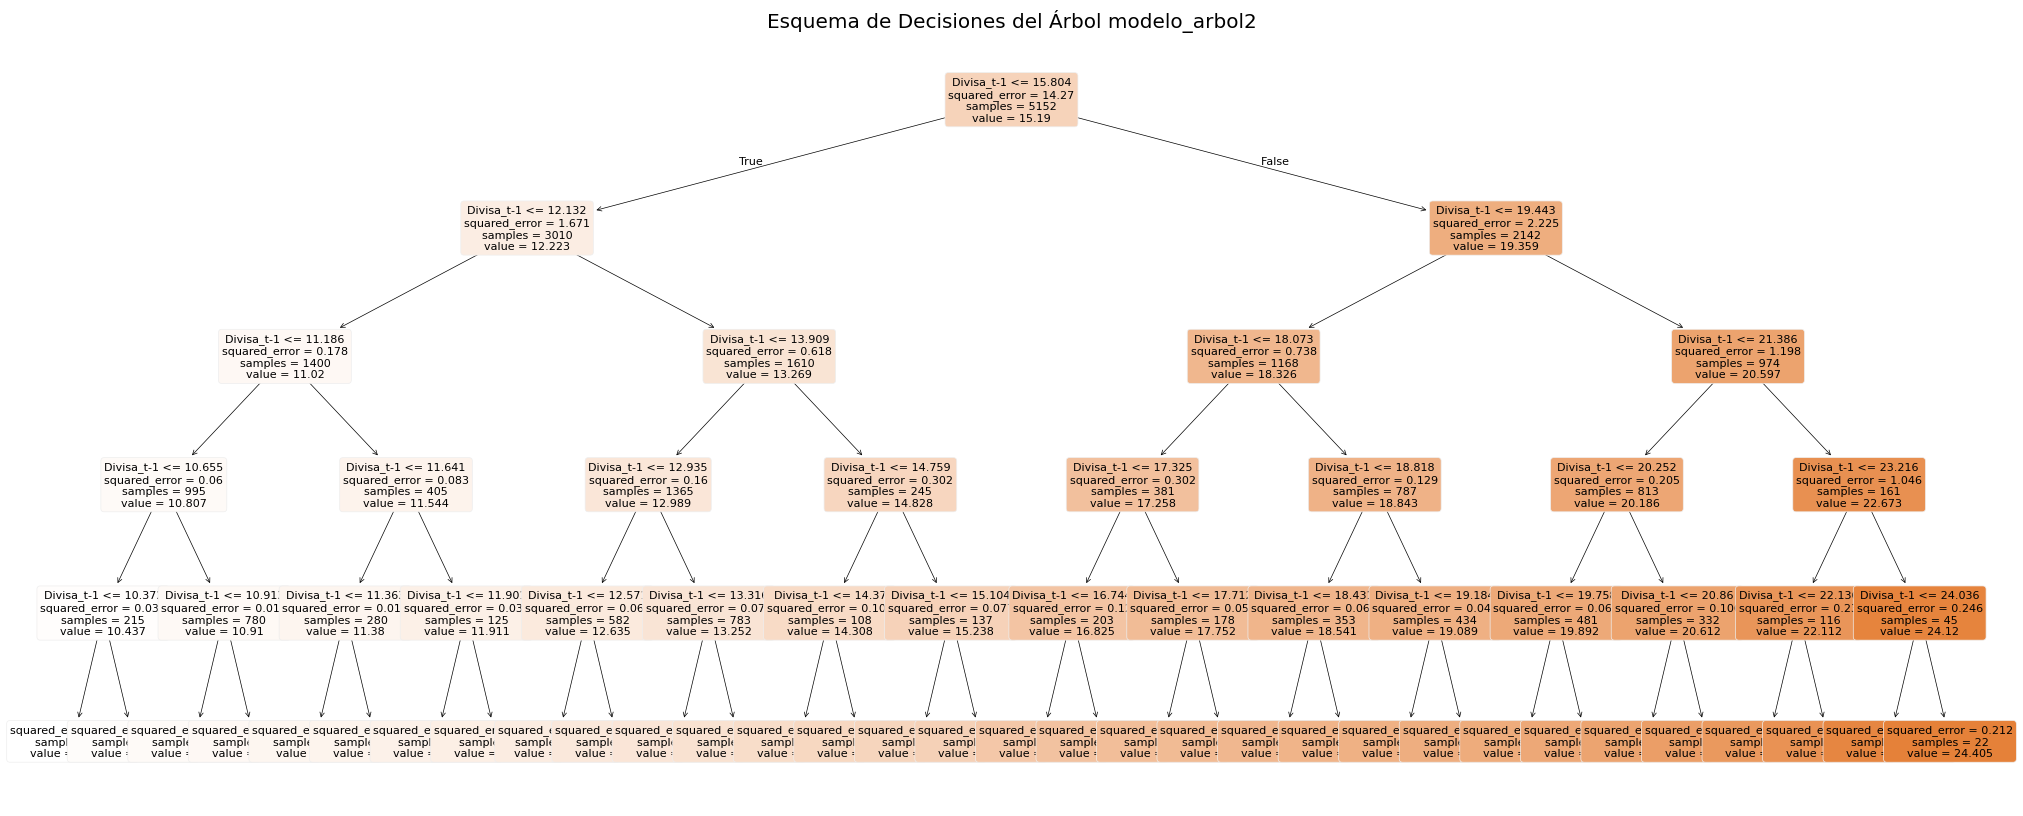

In [354]:

plt.figure(figsize=(25, 10))  # Hacemos la imagen muy ancha para poder visualizar todas las hojas

plot_tree(
    modelo_arbol2,           
    feature_names=X.columns,  
    filled=True,              
    rounded=True,            
    fontsize=8                
)

plt.title("Esquema de Decisiones del Árbol modelo_arbol2")
plt.show()

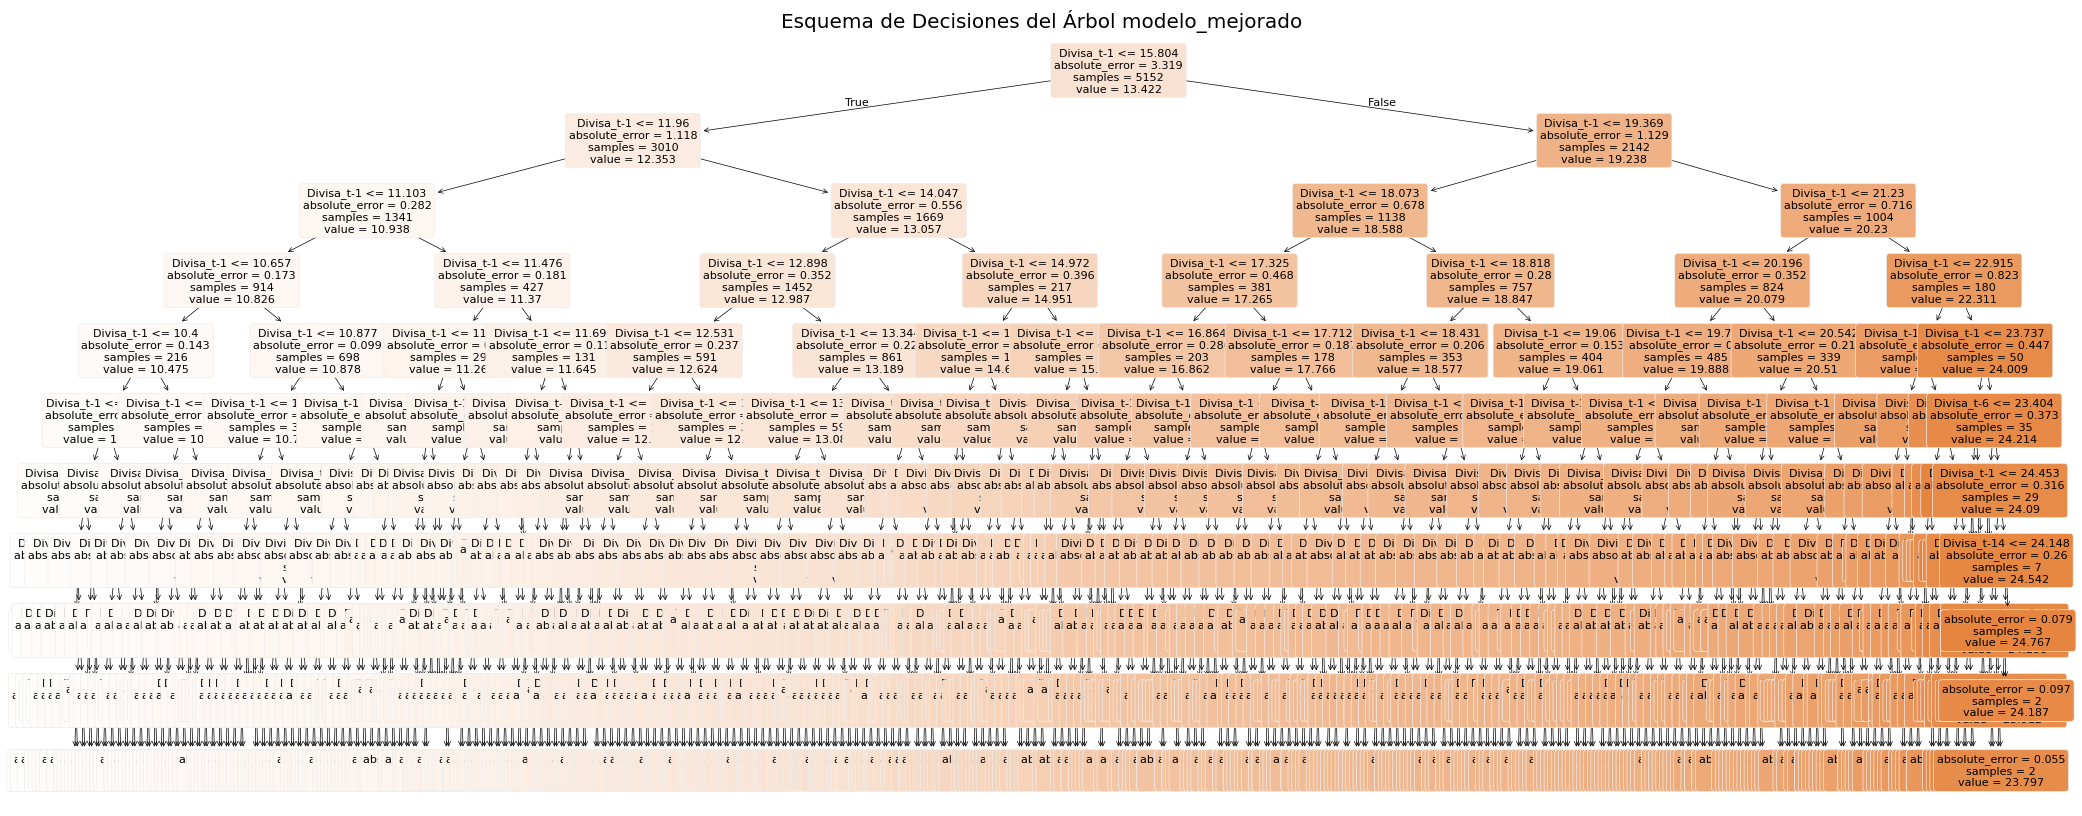

In [355]:

plt.figure(figsize=(25, 10)) #Para poder visualizarla toda hacemos la imagen grande

plot_tree(
    modelo_mejorado,            #modelo entrenado
    feature_names=X.columns,  
    filled=True,             
    rounded=True,            
    fontsize=8              
)

plt.title("Esquema de Decisiones del Árbol modelo_mejorado")
plt.show()

## Ajustar hiperparametros

Profundidad 1: RMSE Test = 1.4440
Profundidad 2: RMSE Test = 0.8423
Profundidad 3: RMSE Test = 0.4215
Profundidad 4: RMSE Test = 0.2631
Profundidad 5: RMSE Test = 0.1823
Profundidad 6: RMSE Test = 0.1651
Profundidad 7: RMSE Test = 0.1634
Profundidad 8: RMSE Test = 0.1618
Profundidad 9: RMSE Test = 0.1740
Profundidad 10: RMSE Test = 0.1864
Profundidad 11: RMSE Test = 0.1901
Profundidad 12: RMSE Test = 0.1982
Profundidad 13: RMSE Test = 0.1984
Profundidad 14: RMSE Test = 0.2042
Profundidad 15: RMSE Test = 0.2019
Profundidad 16: RMSE Test = 0.2032
Profundidad 17: RMSE Test = 0.2072
Profundidad 18: RMSE Test = 0.2082
Profundidad 19: RMSE Test = 0.2069
Profundidad 20: RMSE Test = 0.2068


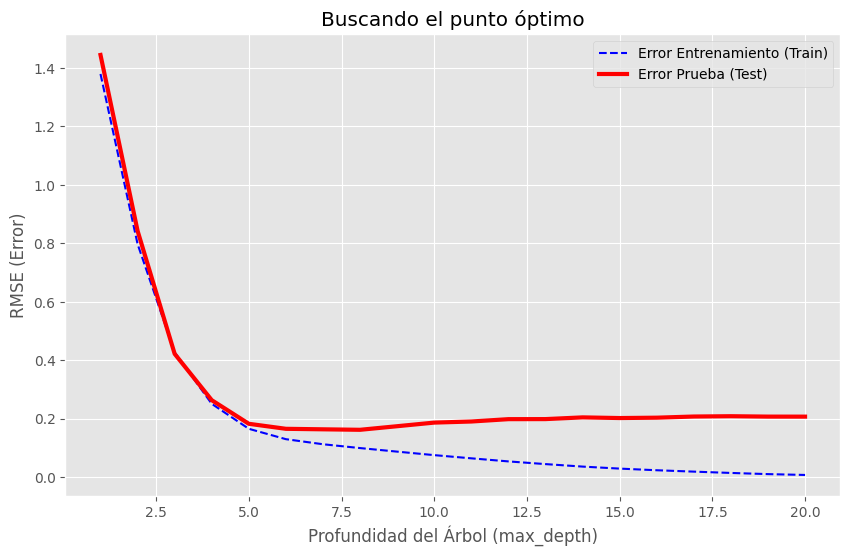


EL MEJOR MODELO ES CON PROFUNDIDAD: 8 (RMSE: 0.1618)


In [357]:
# Listas para guardar los resultados
lista_profundidades = range(1, 21) # Probaremos de 1 a 20
#usaremos el hiperparametro profundidad para poder ajustar el modelo
#con los errores vemos el comportamiento del error que ajusta el modelo y el error que se obtienen cuando ajustamos
#el modelo y lo probamos con datos de prueba
errores_train = []
errores_test = []

for profundidad in lista_profundidades:
    #Actuzalizamos los hiperparametros del arbol
    modelo = DecisionTreeRegressor(max_depth=profundidad, random_state=0)
    
    #lo entrenamos
    modelo.fit(X_train, y_train)
    
    #Se comprueba con los datos de prueba y de entrenamiento
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)
    
    # Calculamos el error cuadratico medio
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    # guardamos los datos
    errores_train.append(rmse_train)
    errores_test.append(rmse_test)
    
    print(f"Profundidad {profundidad}: RMSE Test = {rmse_test:.4f}")

# Ya solo graficasmos las liastas
plt.figure(figsize=(10, 6))
plt.plot(lista_profundidades, errores_train, label='Error Entrenamiento (Train)', color='blue', linestyle='--')
plt.plot(lista_profundidades, errores_test, label='Error Prueba (Test)', color='red', linewidth=3)

plt.xlabel('Profundidad del Árbol (max_depth)')
plt.ylabel('RMSE (Error)')
plt.title('Buscando el punto óptimo')
plt.legend()
plt.grid(True)
plt.show()

# Ya solo buscamso el que mejor error del conjunto de prueba
mejor_rmse = min(errores_test)
mejor_profundidad = lista_profundidades[errores_test.index(mejor_rmse)]
print(f"\nEL MEJOR MODELO ES CON PROFUNDIDAD: {mejor_profundidad} (RMSE: {mejor_rmse:.4f})")

## Tercer modelo: modelo_final

In [358]:
#Usamos el 
modelo_final = DecisionTreeRegressor(
    criterion='absolute_error',  # En vez de 'squared_error' (el default)
    max_depth=8,                 # Profundidad
    min_samples_leaf=2,         # Mínimo de datos por hoja (ayuda a generalizar)
    random_state=0
)

modelo_final.fit(X_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=8,
                      min_samples_leaf=2, random_state=0)

In [359]:
y_pred_test_final = modelo_final.predict(X_test)

In [360]:
#vemos que como el error sobre lo predicho y lo que guardamos para probar bajo
mae = mean_absolute_error(y_test, y_pred_test_final)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_final))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.11828035584294978
RMSE: 0.1655511744456329


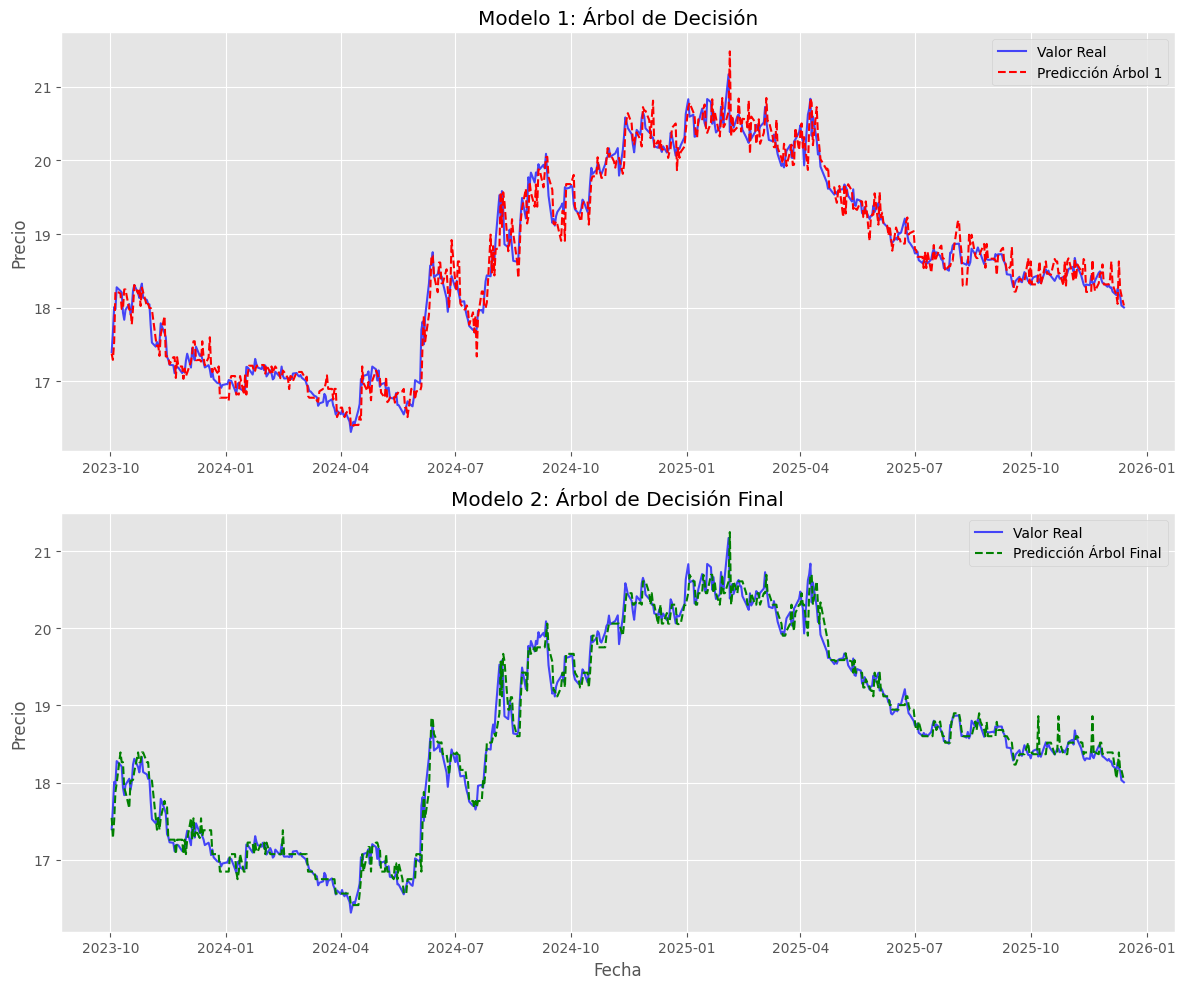

In [361]:
#Hacemos nuevamente la grafica para ver como se comparan en la presicion del modelo.
plt.figure(figsize=(12, 10))

# Subgrafica
plt.subplot(2, 1, 1)
plt.plot(y_test.index, y_test, label='Valor Real', color='blue', alpha=0.7)
plt.plot(y_test.index, y_pred_test, label='Predicción Árbol 1', 
         color='red', linestyle='--')

plt.title('Modelo 1: Árbol de Decisión')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)

# Subgrafica
plt.subplot(2, 1, 2)
plt.plot(y_test.index, y_test, label='Valor Real', color='blue', alpha=0.7)
plt.plot(y_test.index, y_pred_test_final, label='Predicción Árbol Final', 
         color='green', linestyle='--')

plt.title('Modelo 2: Árbol de Decisión Final')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Comparación de los esquemas del modelo_mejorado y modelo_final

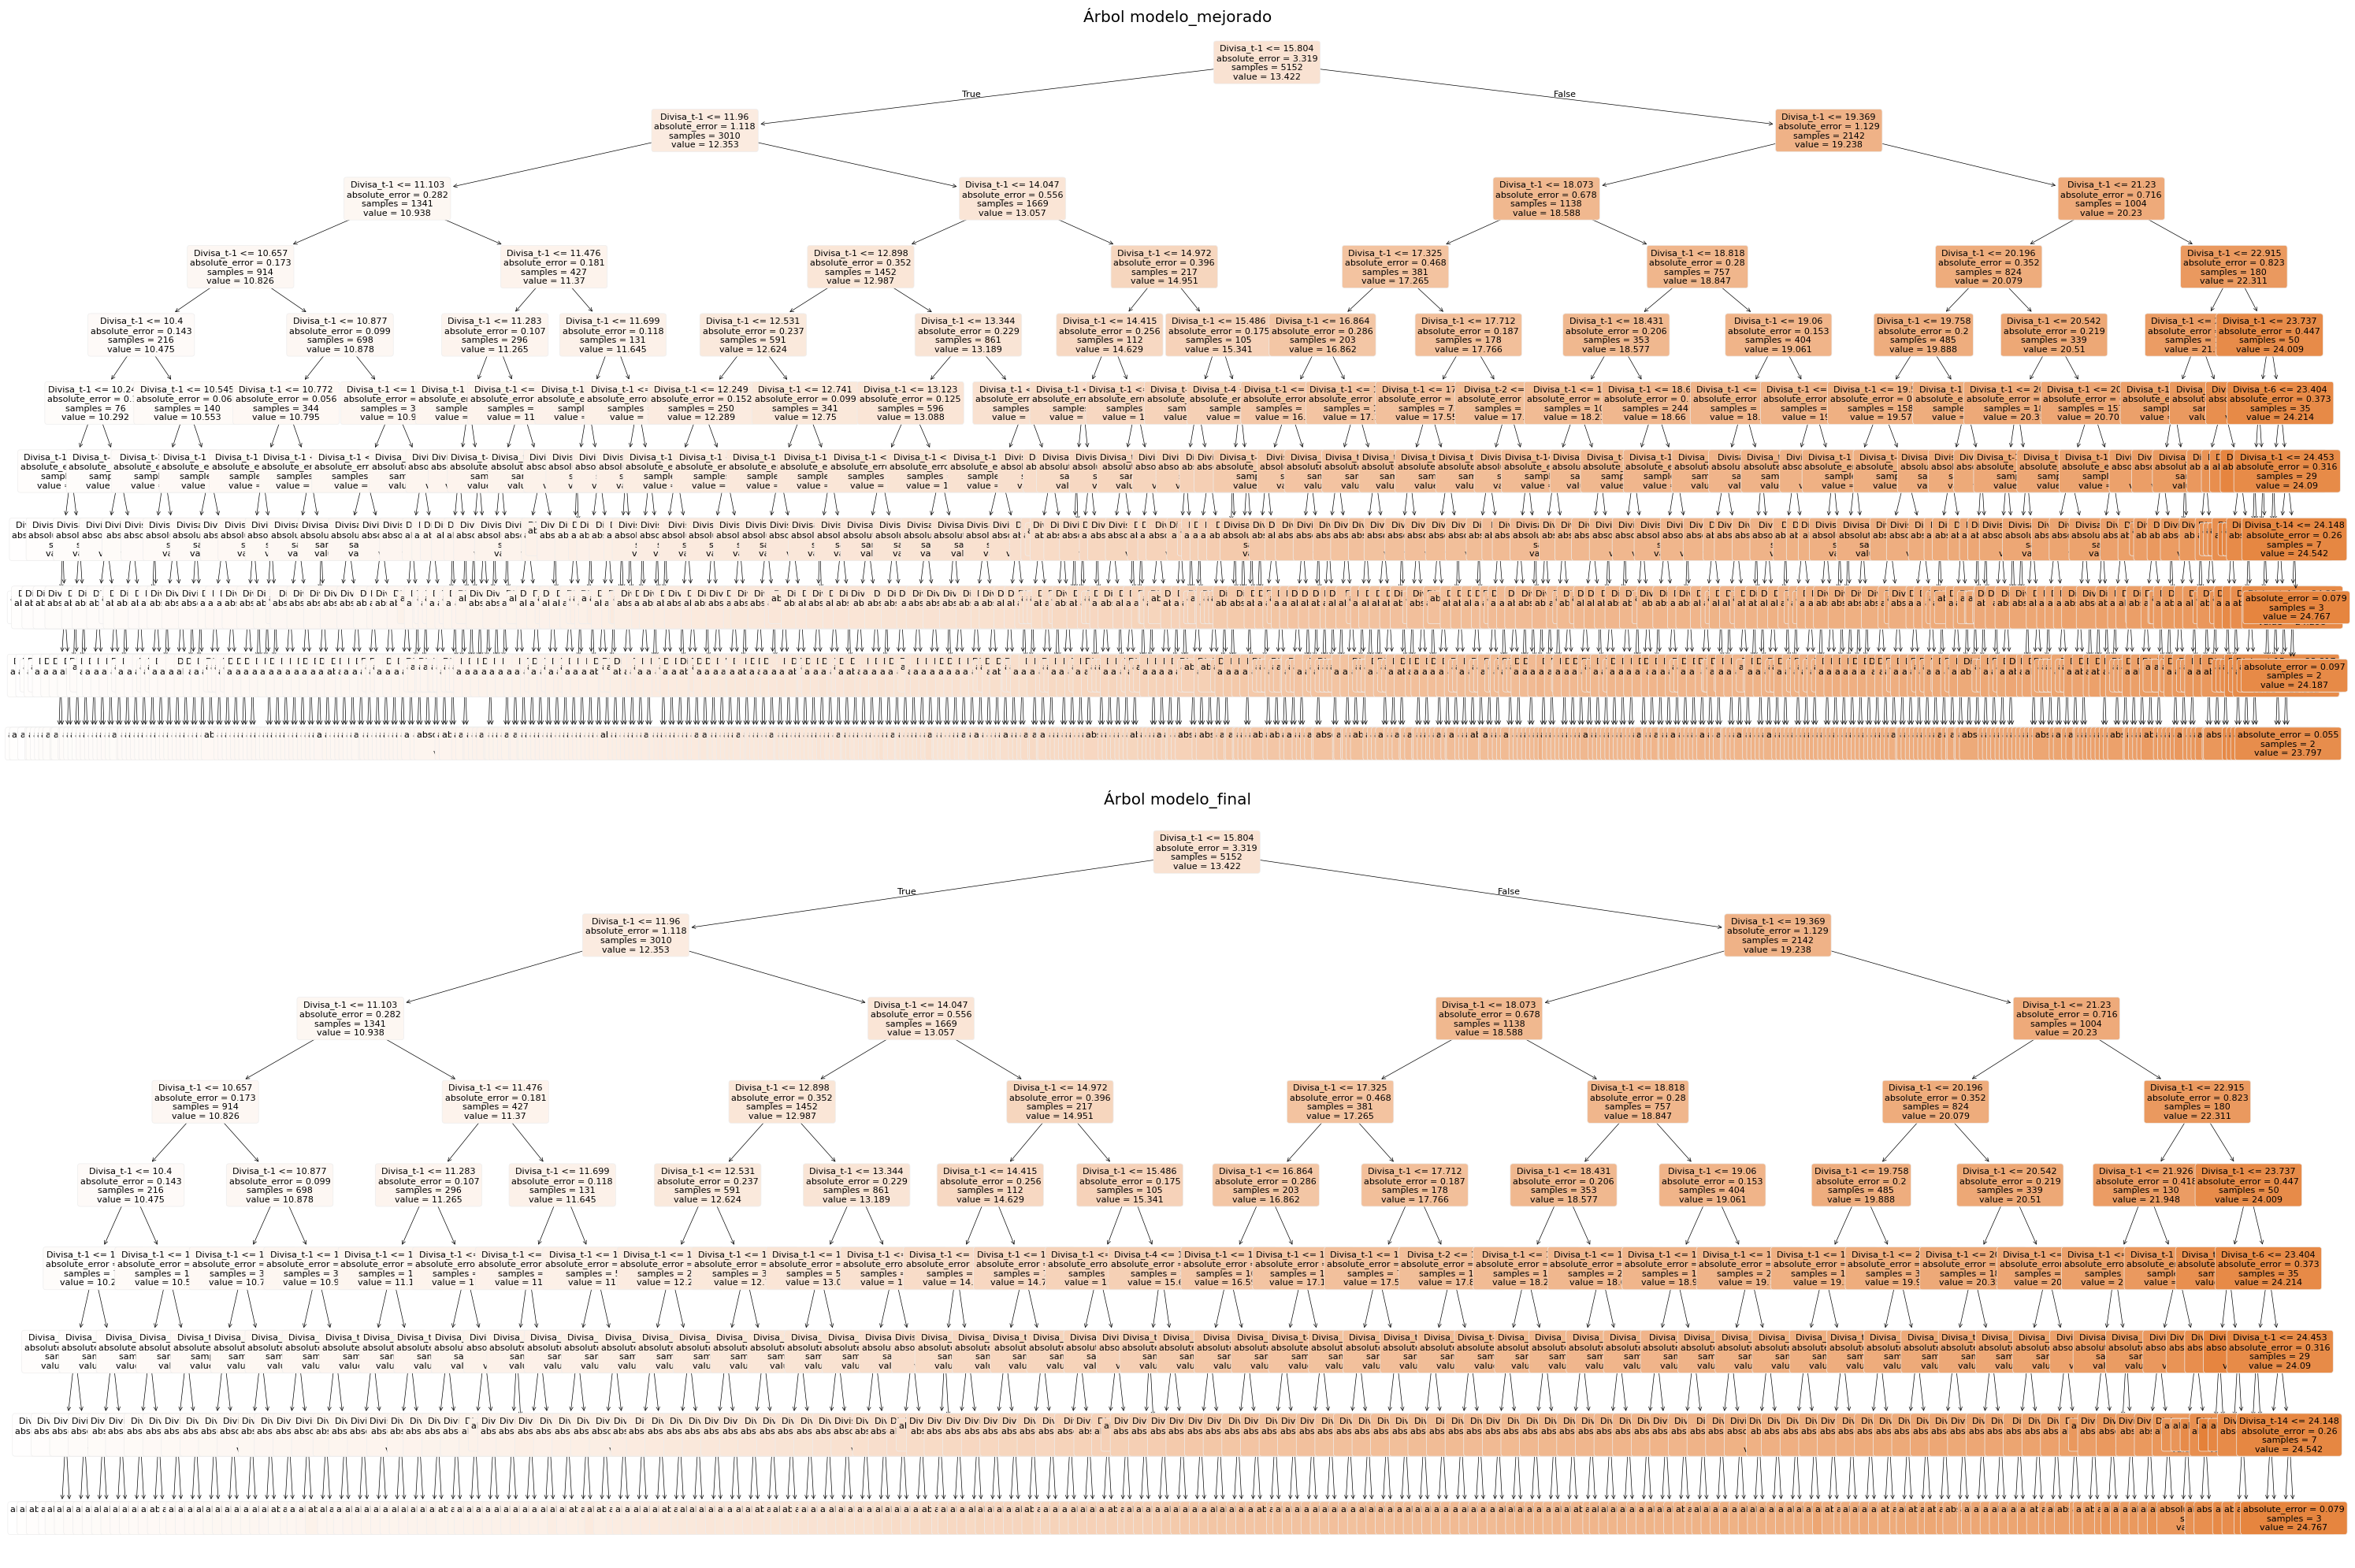

In [370]:
#Comparamos los dos esquemas que mejor resultado nos arrojaron

fig, axes = plt.subplots(2, 1, figsize=(30, 20))

# Árbol 1
plot_tree(
    modelo_mejorado,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    fontsize=8,
    ax=axes[0]
)
axes[0].set_title("Árbol modelo_mejorado")

# Árbol 2
plot_tree(
    modelo_final,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    fontsize=8,
    ax=axes[1]
)
axes[1].set_title("Árbol modelo_final")

plt.tight_layout()
plt.show()

In [371]:
n = 15 

# últimos n valores reales disponibles
ultimos = serie_divp.values[-n:]

X_m = pd.DataFrame([ultimos], columns=[f"Divisa_t-{lag}" for lag in range(n, 0, -1)])

pred_m1 = modelo_final.predict(X_m)[0]
print("Predicción divisa para mañana:", pred_m1)

Predicción divisa para mañana: 18.025800704956055


In [372]:
horizonte = 30
n = 15

p_futuras = []
fechas = []

serie_pred = serie_divp.copy()
serie_pred.index = pd.to_datetime(serie_pred.index, errors="coerce")
serie_pred = serie_pred.dropna()

for _ in range(horizonte):
    ultimos = serie_pred.values[-n:]
    X_n = pd.DataFrame([ultimos], columns=[f"Divisa_t-{lag}" for lag in range(n, 0, -1)])

    pred = modelo_final.predict(X_n)[0]
    p_futuras.append(pred)

    nueva_fecha = serie_pred.index[-1] + pd.Timedelta(days=1)
    fechas.append(nueva_fecha)

    # realimentación: usar la predicción como si fuera el valor real del siguiente día
    serie_pred.loc[nueva_fecha] = pred

df_pronostico = pd.DataFrame({"Fecha": fechas, "Divisa_predicha": p_futuras}).set_index("Fecha")
print(df_pronostico.head())

            Divisa_predicha
Fecha                      
2025-12-15        18.025801
2025-12-16        18.025801
2025-12-17        18.025801
2025-12-18        18.025801
2025-12-19        18.025801


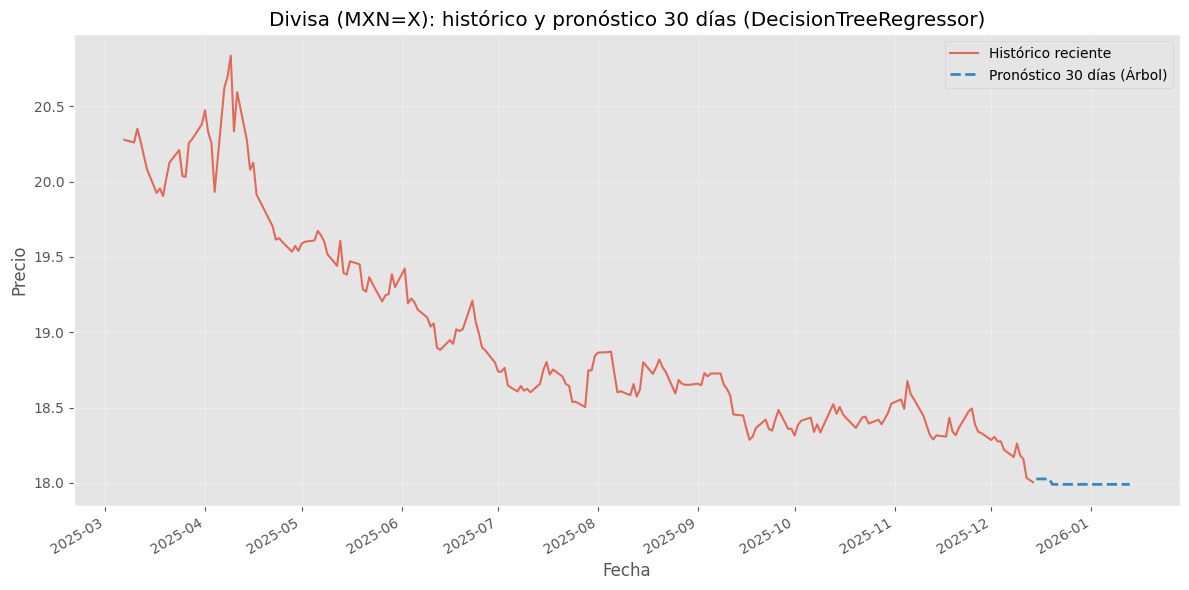

In [373]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

serie_divp.iloc[-200:].plot(label="Histórico reciente", alpha=0.8)
df_pronostico["Divisa_predicha"].plot(label="Pronóstico 30 días (Árbol)", linestyle="--", linewidth=2)

plt.title("Divisa (MXN=X): histórico y pronóstico 30 días (DecisionTreeRegressor)")
plt.ylabel("Precio")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Caso Bitcoin Regresión de Soporte Vectorial (SVR)

In [ ]:
#Ahora construimos las X y las Y
# recordamos las x seran nuestras variables independientes y Y la que depende de todas estas caracteristicas

In [292]:
#Para el caso del bitcoin construimos el conjunto como sigue
def construir_X_btc(serie, tiempo=5): #fijamos el tiempo por defecto en 5 pero lo podemos cambiarcuando queramos

    #primero se crea una copia de la serie de valores que le demos en nuestro caso la columna con
    #su indece que sera una fecha
    
    df = pd.DataFrame(serie.copy())
    df.columns = ["bit_t"]  # Con esto nombramos la columna objetivo

    # Crear columnas para el valor del bitcoin en dias anteriores al valo objetivo
    #el .shift(lag) es lo que hace que se desplacen los valores hacia abajo osea va tomando tiempos, despues del primero
    #ya que nuestros datos estan en una sola columna.
    
    for lag in range(1, tiempo + 1):
        df[f"bit_t-{lag}"] = df["bit_t"].shift(lag)
        
    #Como no sabemos si los valores que tenemos nos alcanza para llenar todos lo X posibles
    #en ocaciones no alcanzaremos a llenar todos en este caso eliminamos a todos con valores faltantes
    df = df.dropna()

    # Se reordenan los datos osea los invierte por nuestra variable objetivo queda al incio ya solo la
    #pasamos al final.
    cols_features = [f"bit_t-{lag}" for lag in range(tiempo, 0, -1)]
    cols = cols_features + ["bit_t"]
    df = df[cols]

    return df

In [293]:
#Ahora usamo la funcion que hicismo y vemos como se ve
#para esto usamo un tiempo grande o relativamente grande porque el precio del bitcoin es muy volatil
#necesitamos informacion de muchos dias anteriores para ver una tendencia.

df_btc = construir_X_btc(serie_btc, tiempo=30)

#El metodo .head() solo nos muestra algunos valores.
df_btc.head()

bit_t-30      bit_t-29      bit_t-28      bit_t-27  \
Date                                                                 
2023-01-31  16625.080078  16688.470703  16679.857422  16863.238281   
2023-02-01  16688.470703  16679.857422  16863.238281  16836.736328   
2023-02-02  16679.857422  16863.238281  16836.736328  16951.968750   
2023-02-03  16863.238281  16836.736328  16951.968750  16955.078125   
2023-02-04  16836.736328  16951.968750  16955.078125  17091.144531   

                bit_t-26      bit_t-25      bit_t-24      bit_t-23  \
Date                                                                 
2023-01-31  16836.736328  16951.968750  16955.078125  17091.144531   
2023-02-01  16951.968750  16955.078125  17091.144531  17196.554688   
2023-02-02  16955.078125  17091.144531  17196.554688  17446.292969   
2023-02-03  17091.144531  17196.554688  17446.292969  17934.896484   
2023-02-04  17196.554688  17446.292969  17934.896484  18869.587891   

                bit_t-22      bit_t-21  ...       bit_t-9       bit_t-8  \
Date                                    ...                               
2023-01-31  17196.554688  17446.292969  ...  22720.416016  22934.431641   
2023-02-01  17446.292969  17934.896484  ...  22934.431641  22636.468750   
2023-02-02  17934.896484  18869.587891  ...  22636.468750  23117.859375   
2023-02-03  18869.587891  19909.574219  ...  23117.859375  23032.777344   
2023-02-04  19909.574219  20976.298828  ...  23032.777344  23078.728516   

                 bit_t-7       bit_t-6       bit_t-5       bit_t-4  \
Date                                                                 
2023-01-31  22636.468750  23117.859375  23032.777344  23078.728516   
2023-02-01  23117.859375  23032.777344  23078.728516  23031.089844   
2023-02-02  23032.777344  23078.728516  23031.089844  23774.566406   
2023-02-03  23078.728516  23031.089844  23774.566406  22840.138672   
2023-02-04  23031.089844  23774.566406  22840.138672  23139.283203   

                 bit_t-3       bit_t-2       bit_t-1         bit_t  
Date                                                                
2023-01-31  23031.089844  23774.566406  22840.138672  23139.283203  
2023-02-01  23774.566406  22840.138672  23139.283203  23723.769531  
2023-02-02  22840.138672  23139.283203  23723.769531  23471.871094  
2023-02-03  23139.283203  23723.769531  23471.871094  23449.322266  
2023-02-04  23723.769531  23471.871094  23449.322266  23331.847656  

[5 rows x 31 columns]

In [294]:
#Esto  lo hacemos para poder dividir las X y las Y 
#Para las X_list solo no tomamamos la columna bit_t

X_list_btc = df_btc.drop(columns=["bit_t"])

#  sy para Y solo la columna bit_t
y_list_btc = df_btc["bit_t"]

In [295]:
Xbtc = np.array(X_list_btc)
ybtc = np.array(y_list_btc)

In [296]:
#Ahora dividimos estos en prueba y entrenamiento
# shuffle=False para mantener el orden cronológico
#sin no los revuelve en ese caso lo que haria la funcion es revolver al azar y eso nos sirve porque relacionarion 
#valores de un año con el de otro año, pero buscamos algo secuencial que pasa año con año

#Ahora hacemos la division para despues comprobar que tan bien lo hace el modelo antes de predecir 
#fechas que aun no pasan, veremos como se comporta nuestro modelo con valores que ya conocemos


X_trainbtc, X_testbtc, y_trainbtc, y_testbtc = train_test_split(X_list_btc, y_list_btc, test_size=0.05, shuffle=False)

#Ya solo vemos con que cantidad de datos vamos a entrenar y con cuantos podremos probar
print(f"Entrenamos con los primeros {len(X_trainbtc)} días")
print(f"Probamos con los últimos {len(X_testbtc)} días")

Entrenamos con los primeros 996 días
Probamos con los últimos 53 días


## Escalamos datos

In [297]:
# Ahora escalamos las caracteristicas X para que la convergencia sea mas rapida y el algoritmo no
#trabaje con numero muy grandes, esto lo hacesmo solo para el las caracteristicas X, y no para el valor
#"Y" ya que este si debe conservar su valor real para poder interpretar las soluciones que nos de

scaler = StandardScaler()
X_train_scl_btc = scaler.fit_transform(X_trainbtc)
X_test_scl_btc = scaler.transform(X_testbtc)

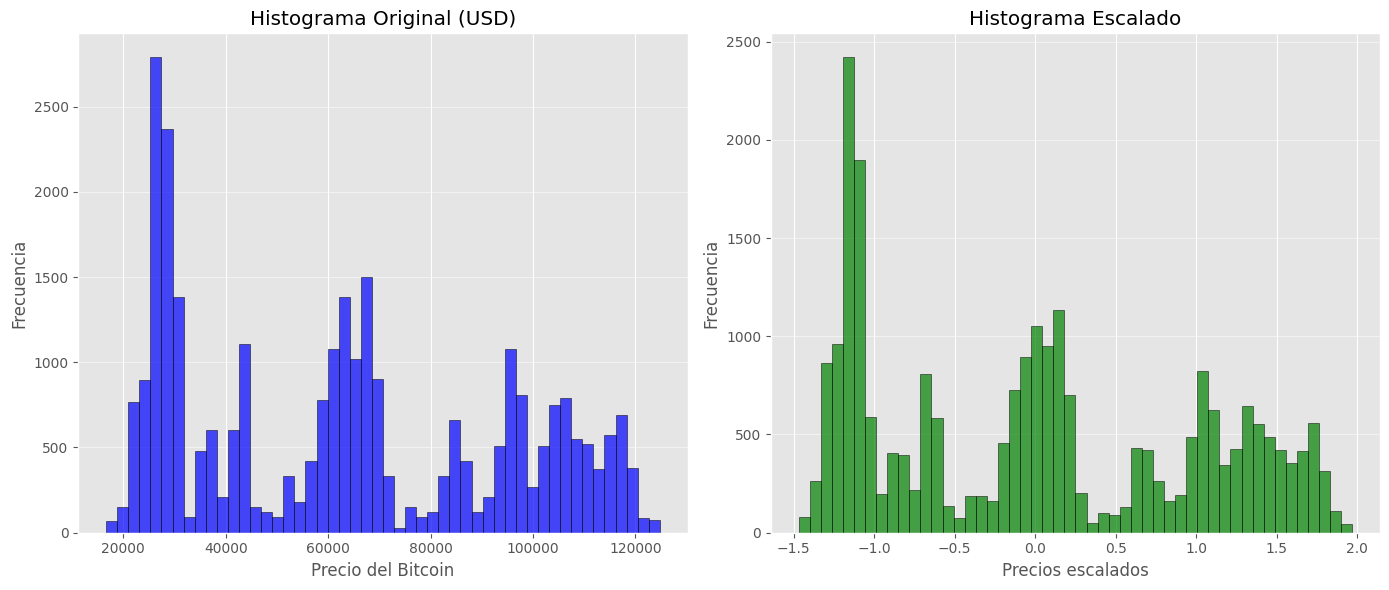

In [298]:
#Ahora solo vemos que nuestros datos este escalados y vemos la comparación
# Vamos a aplanar los datos (flatten) ya que practicamente es un arreglo de varios renglones
# y ver la distribución general, no día por día, osea la frecuencia de precios deben estar en 
#una escala pequeña
#ocupamos astype(float) para que python reconozca que son numero y no letras
# Original (antes de escalar): aplana a 1D
d_original = np.asarray(X_trainbtc, dtype=float).flatten()

# Escalado: también aplana a 1D
d_escalada = np.asarray(X_train_scl_btc, dtype=float).flatten()

plt.figure(figsize=(14, 6))

# Precios en Dólares
plt.subplot(1, 2, 1)
plt.hist(d_original, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histograma Original (USD)')
plt.xlabel('Precio del Bitcoin')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.5)

# Preciso escalados
plt.subplot(1, 2, 2)
plt.hist(data_escalada, bins=50, color='green', alpha=0.7, edgecolor='black')
plt.title('Histograma Escalado')
plt.xlabel('Precios escalados')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

In [299]:
#Ahora entrenamos con la libreria de SVR para este caso
#usamos los parametros 'rbf' es una funcion para poder ver como se relacionan los 
#datos de X con los de Y, usa una funcion que ajusta mejor porque el comportamiento no es lineal.

#el C para penalizar, osea es el parametro de castigo, es el encargado de decidir que tanto error tendra el modelo
#con un valor alto es estricto y con un valor bajo es relajado pero es propenso a tener mas error

#y la gamma para ver que tanto de divide, osea que tanto afectan los datos cercanos con un gamma alto los valores
#cercanos no se influencian, pero con una gamma baja su alcance es mayor.

#Con la primera instruccion creamos nuestro modelo osea con que parametros va a ser ejecutado

svr_rbf = SVR(kernel='rbf', C=1e5, gamma=0.01, epsilon=50)

#Con el metodo .fit ya entrenamos nuestro modelo

svr_rbf.fit(X_train_scl_btc, y_trainbtc)

SVR(C=100000.0, epsilon=50, gamma=0.01)

In [300]:
#Ahora con este metodo vemos que tambien lo hicimos 

svr_coincidencia = svr_rbf.score(X_test_scl_btc, y_testbtc)
print(f"Precisión del modelo (R^2): {svr_coincidencia:.4f}")

Precisión del modelo (R^2): 0.9164


In [301]:
#con esto comprobamos que tanto se hacerca a nuestro valores,
#primero creamos la prediccion
y_pred_btc = svr_rbf.predict(X_test_scl_btc)

In [302]:
#Antes de graficar vesmos que las escalas correspondan
print(y_testbtc[:5], y_testbtc.dtype)
print(y_pred_btc[:5], y_pred_btc.dtype)

Date
2025-10-23    110069.726562
2025-10-24    111033.921875
2025-10-25    111641.726562
2025-10-26    114472.445312
2025-10-27    114119.328125
Name: bit_t, dtype: float64 float64
[108582.23198976 110099.2147611  111191.07845539 111398.27319539
 113043.60528091] float64


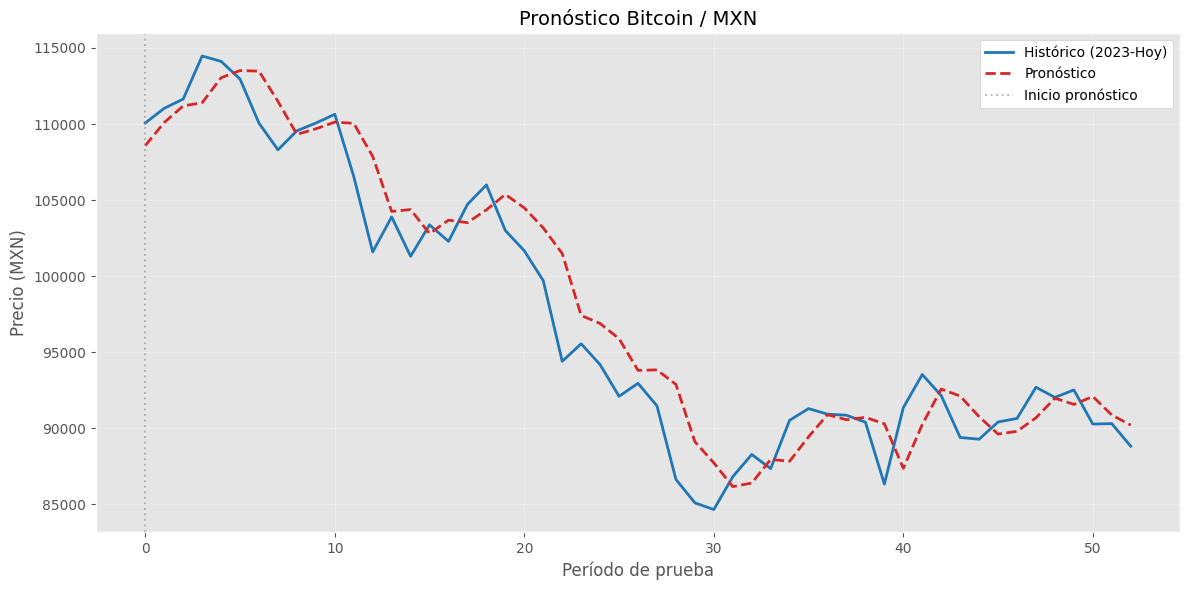

In [303]:
# Ahora hacemos la coparacion de los dos
plt.style.use('ggplot')

plt.figure(figsize=(12, 6))

# Gráfica de datos reales(azul)
plt.plot(range(len(y_testbtc)), y_testbtc, 
         label='Histórico (2023-Hoy)', 
         color='tab:blue', 
         linewidth=2)

# Gráfica de predicciones (Rojo Punteado) ---
plt.plot(range(len(y_pred_btc)), y_pred_btc, 
         label='Pronóstico', 
         color='tab:red', 
         linestyle='--',    
         linewidth=2)

# Línea vertical donde empieza la predicción
plt.axvline(x=0, color='gray', linestyle=':', alpha=0.5, label='Inicio pronóstico')

# Detalles del gráfico
plt.title('Pronóstico Bitcoin / MXN', fontsize=14)
plt.xlabel('Período de prueba')
plt.ylabel('Precio (MXN)')
plt.legend(facecolor='white', framealpha=1)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [306]:
#Para ver que valores nos combienen primero dejamos fijo uno de los parametros y luego
#vamos ajutando, para el valor de C escojemos pocos valores antes de que caiga en un sobreajuste

v_C = [1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]
gamma_fijo = 0.01
eps_fijo = 50

#Con esto guardamos los valores de las metricas
errores_train = []
errores_test = []

for C in v_C:
     #Configurar el modelo con el C
    modelo = SVR(kernel='rbf', C=C, gamma=gamma_fijo, epsilon=eps_fijo)
    
    #Entrenamos al modelo
    modelo.fit(X_train_scl_btc, y_trainbtc)
    
    # Predecir en train y test, para ver que tal lo hace con los valores de entrenamiento y lo valores
    #de prueba que pueden considerarse nuevos.
    
    y_pred_train = modelo.predict(X_train_scl_btc).astype(float)
    y_pred_test  = modelo.predict(X_test_scl_btc).astype(float)
    
    # Calculamos el rmse
    rmse_train = np.sqrt(mean_squared_error(y_trainbtc, y_pred_train))
    rmse_test  = np.sqrt(mean_squared_error(y_testbtc,  y_pred_test))
    #Los guardamos en nuestro arreglo
    errores_train.append(rmse_train)
    errores_test.append(rmse_test)
    
    print(f"C={C:.0e}: RMSE Test = {rmse_test:.4f}")


C=1e+02: RMSE Test = 12013.5951
C=1e+03: RMSE Test = 6650.9163
C=1e+04: RMSE Test = 3810.3934
C=1e+05: RMSE Test = 2589.8196
C=1e+06: RMSE Test = 2371.0545
C=1e+07: RMSE Test = 2509.6974
C=1e+08: RMSE Test = 2972.0394


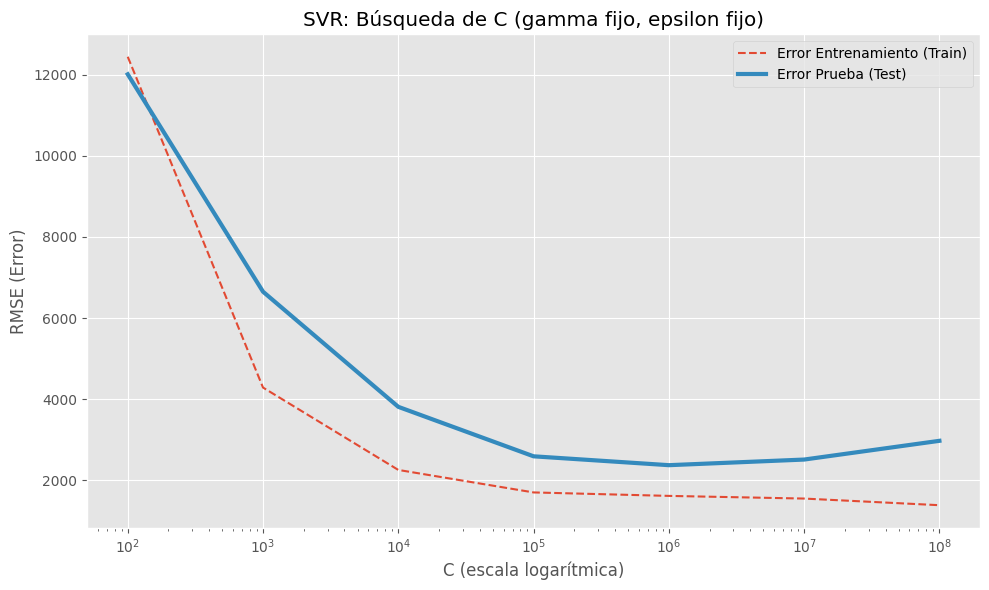


MEJOR MODELO CON C = 1e+06 (RMSE Test: 2371.0545)


In [307]:
#Ahora graficamos lo que obtuvimos
plt.figure(figsize=(10, 6))

plt.plot(v_C, errores_train, label='Error Entrenamiento (Train)', 
         linestyle='--')
plt.plot(v_C, errores_test, label='Error Prueba (Test)', 
         linewidth=3)

plt.xscale('log')  # reescalamos para que se vea mejor
plt.xlabel('C (escala logarítmica)')
plt.ylabel('RMSE (Error)')
plt.title('SVR: Búsqueda de C (gamma fijo, epsilon fijo)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Encontrar el mejor C según RMSE de test
mejor_rmse = min(errores_test)
mejor_C = v_C[errores_test.index(mejor_rmse)]
print(f"\nMEJOR MODELO CON C = {mejor_C:.0e} (RMSE Test: {mejor_rmse:.4f})")

In [308]:
#Con esto ya tenemos nuestro mejor modelo con gamma y epsilon fija.
#La usamos para nuestro modelo nuevo.
svr_rbf = SVR(kernel='rbf', C=1e6, gamma=0.01, epsilon=50)

#Con el metodo .fit ya entrenamos nuestro modelo

svr_rbf.fit(X_train_scl_btc, y_trainbtc)

SVR(C=1000000.0, epsilon=50, gamma=0.01)

In [309]:
#Ahora primero predecimos el valor del bitcoin mañana y eso lo hacemos desde nuestra serie original la que tiene 
#todos los datos
tiempo = 30  #el mismo que usamos para construir nuestras X
serie_btc = datos_btc['Close']
serie_n = serie_btc   # por si acaso
ultimos_precios = serie_n.values[-tiempo:] 


In [310]:
#Ahora solo usamos los ultimos precios o valores
X_m = pd.DataFrame([ultimos_precios],columns=[f"bit_t-{lag}" for lag in range(tiempo, 0, -1)])

In [311]:
X_m = np.array(X_m)

In [312]:
X_m_scl = scaler.transform(X_m)

In [313]:
#Solo usamos los valores escalados con esto tenemos el valor para mañana
pred_m = svr_rbf.predict(X_m_scl)[0]
print("Predicción para Bitcoin mañana:", pred_m)

Predicción para Bitcoin mañana: 89016.1447263694


In [194]:
warnings.filterwarnings("ignore", category=UserWarning) 

horizonte = 30 
p_futuras = []
fechas = []

# Limpieza inicial

serie_n2 = serie_btc.copy()
serie_n2.index = pd.to_datetime(serie_n2.index, errors='coerce')
serie_n2 = serie_n2.dropna()
serie_pred = serie_n2.copy()

for paso in range(horizonte):
    ultimos = serie_pred.values[-tiempo:]
    
    # Creamos el DataFrame temporal
    X_n = pd.DataFrame([ultimos], columns=[f"bit_t-{lag}" for lag in range(tiempo, 0, -1)])
    
    # --- CORRECCIÓN AQUÍ ---
    # Agregamos .values para pasar solo los números al scaler y evitar el warning
    X_n_scl = scaler.transform(X_n.values) 
    
    pred = svr_rbf.predict(X_n_scl)[0]
    p_futuras.append(pred)
    
    n_fecha = serie_pred.index[-1] + pd.Timedelta(days=1)
    fechas.append(n_fecha)
    serie_pred.loc[n_fecha] = pred 

df_pronostico = pd.DataFrame({"Fecha": fechas,"Btc_predicho": p_futuras}).set_index("Fecha")
print(df_pronostico.head())

            Btc_predicho
Fecha                   
2025-12-15  89938.899608
2025-12-16  89924.658026
2025-12-17  89783.820059
2025-12-18  89188.580811
2025-12-19  88990.241833


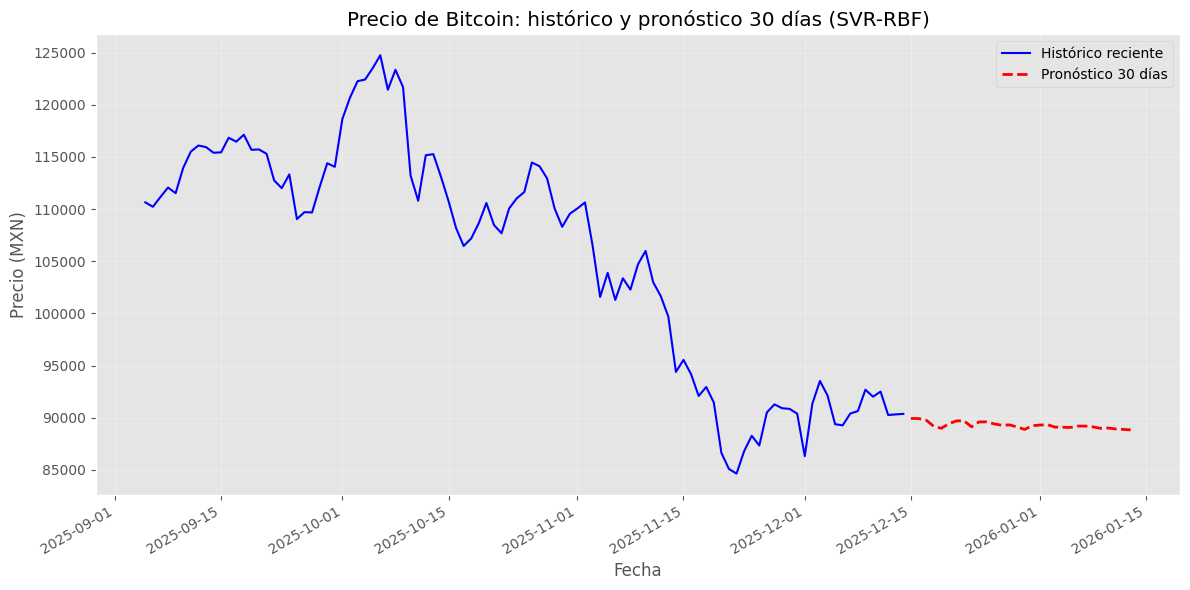

In [314]:
# Aseguramos que los datos sean números float
serie_n2 = pd.to_numeric(serie_n2, errors='coerce')
serie_n2 = serie_n2.dropna()

plt.figure(figsize=(12, 6))

# Graficamos los últimos 100 días
serie_n2.iloc[-100:].plot(label="Histórico reciente", color="blue")

# Graficamos lo que se calculo 
df_pronostico["Btc_predicho"].plot(label="Pronóstico 30 días", linestyle="--", linewidth=2, color="red")

# 4. Decoración
plt.title("Precio de Bitcoin: histórico y pronóstico 30 días (SVR-RBF)")
plt.ylabel("Precio (MXN)")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()